In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

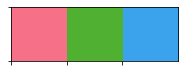

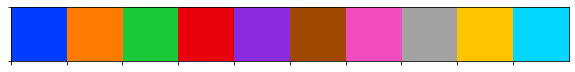

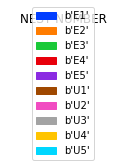

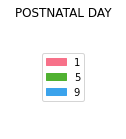

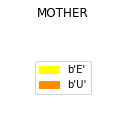

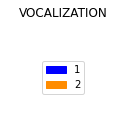

In [2]:
from audiovocana.color import (
    COLORS,
    MOTHERS,
    POSTNATALDAYS,
)

In [3]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set(style="white", palette="bright", color_codes=True)
sns.despine(left=True)

from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import get_dataframe

PLOT = True
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results/1d_distributions"

~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


<Figure size 432x288 with 0 Axes>

In [4]:
# full
csv_path = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/full/xlsx_files"
audio_folder = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"

In [5]:
df = get_dataframe(
    xlsx_folder=xlsx_folder,
    audio_folder=audio_folder,
    csv_path=csv_path,
    save=True
)
print(f"Nb audibles = {len(df[df.vocalization == 1])}")
print(f"Nb USVs = {len(df[df.vocalization == 2])}")
print(f"Audible events represents the {len(df[df.vocalization == 1])/len(df)}% of total.")

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings
Nb audibles = 2204
Nb USVs = 2013
Audible events represents the 0.522646431112165% of total.


In [6]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


In [7]:
keys =  [
    'vocalization',
    'mother',
    'year',
    'nest',
    'postnatalday',
    'mean_sbw',
    'mean_sc',
    'mean_sf',
    'mean_zrc',
]
df = pd.DataFrame.from_records([
    {k: sample[k].numpy() for k in keys}
    for sample in dataset
]).rename({
    'mean_sbw': 'mean_spectral_band_width',
    'mean_sc': 'mean_spectral_centroid',
    'mean_sf': 'mean_spectral_flatness',
    'mean_zrc': 'mean_zero_crossing_rate'
}, axis=1)

df.head()

,vocalization,mother,year,nest,postnatalday,mean_spectral_band_width,mean_spectral_centroid,mean_spectral_flatness,mean_zero_crossing_rate
0,2,b'E',19,b'E3',1,20303.414062,67187.867188,0.004164,0.504169
1,2,b'E',19,b'E3',1,33599.847656,64034.972656,0.209488,0.519343
2,2,b'E',19,b'E3',1,27601.744141,61757.261719,0.028362,0.451025
3,1,b'E',19,b'E3',1,30017.888672,27213.066406,0.015524,0.104209
4,2,b'E',19,b'E3',1,24235.062500,63779.078125,0.012117,0.472212


# PROOF OF CONCEPT : simple audio features AUDIBLE VS USV

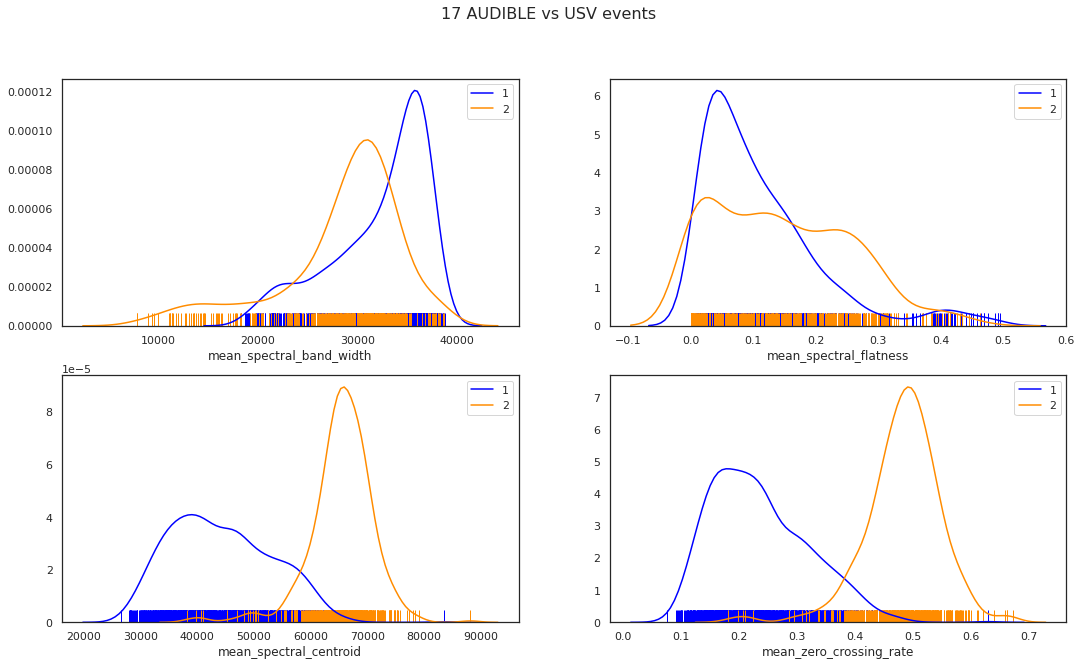

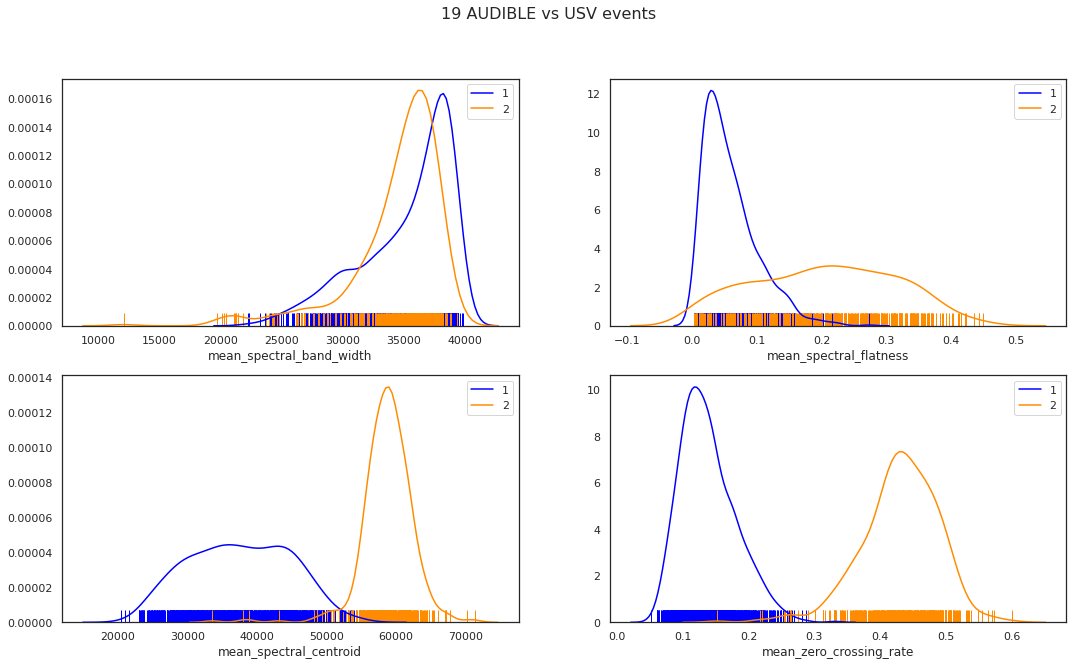

In [8]:
dicc = COLORS['vocalization']

EVENTS = [1, 2]

P = {
    p: df[(df.vocalization == p)]
    for p in EVENTS
}

for YEAR in [17, 19]:

    PY = {
        p: P[p][P[p].year == YEAR]
        for p in EVENTS 
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE vs USV events'
    f.suptitle(title, fontsize=16)

    for p in EVENTS:
        sns.distplot(PY[p].mean_spectral_band_width, color=dicc[p],  hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{p}"})

    for p in EVENTS:
        sns.distplot(PY[p].mean_spectral_flatness,color=dicc[p],  hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{p}"})

    for p in EVENTS:
        sns.distplot(PY[p].mean_spectral_centroid, color=dicc[p],  hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{p}"})

    for p in EVENTS:
        sns.distplot(PY[p].mean_zero_crossing_rate, color=dicc[p],  hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{p}"})
        
    f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

# simple audio features distribution by postnatal day

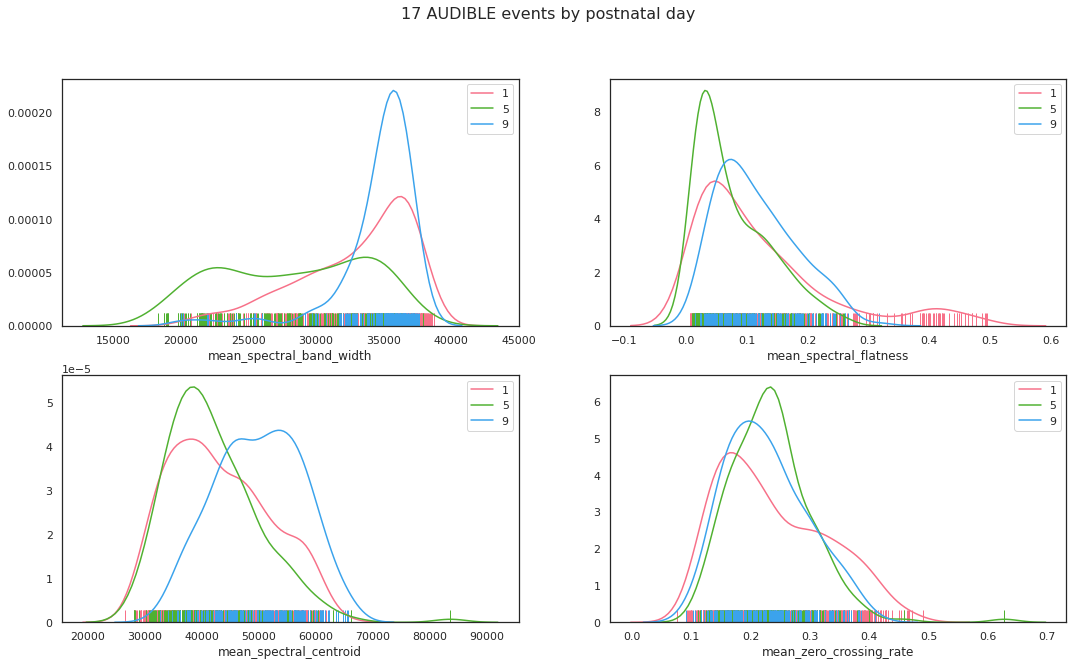

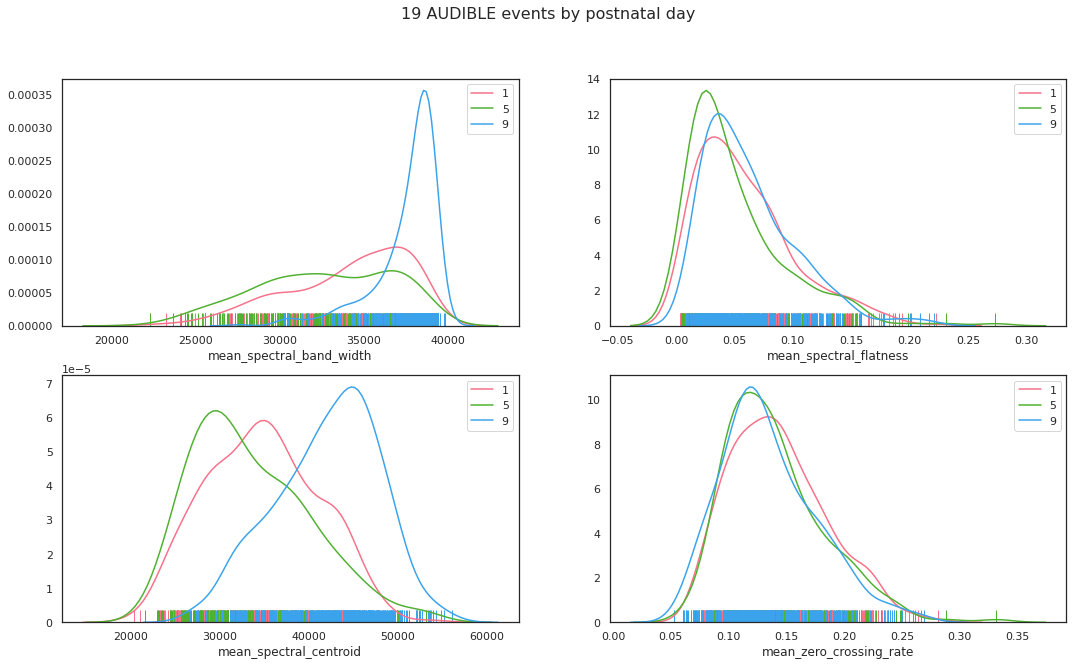

In [9]:
dicc_pnds = COLORS['postnatalday']

P = {
    p: df[(df.postnatalday == p) & (df.vocalization == 1)]
    for p in POSTNATALDAYS
}

for YEAR in [17, 19]:

    PY = {
        p: P[p][P[p].year == YEAR]
        for p in POSTNATALDAYS 
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by postnatal day'
    f.suptitle(title, fontsize=16)

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_band_width, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_flatness,color=dicc_pnds[p],  hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_centroid, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_zero_crossing_rate, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{p}"})
        
    f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

# simple audio features distribution for experienced (E) vs unexperienced (U) mothers

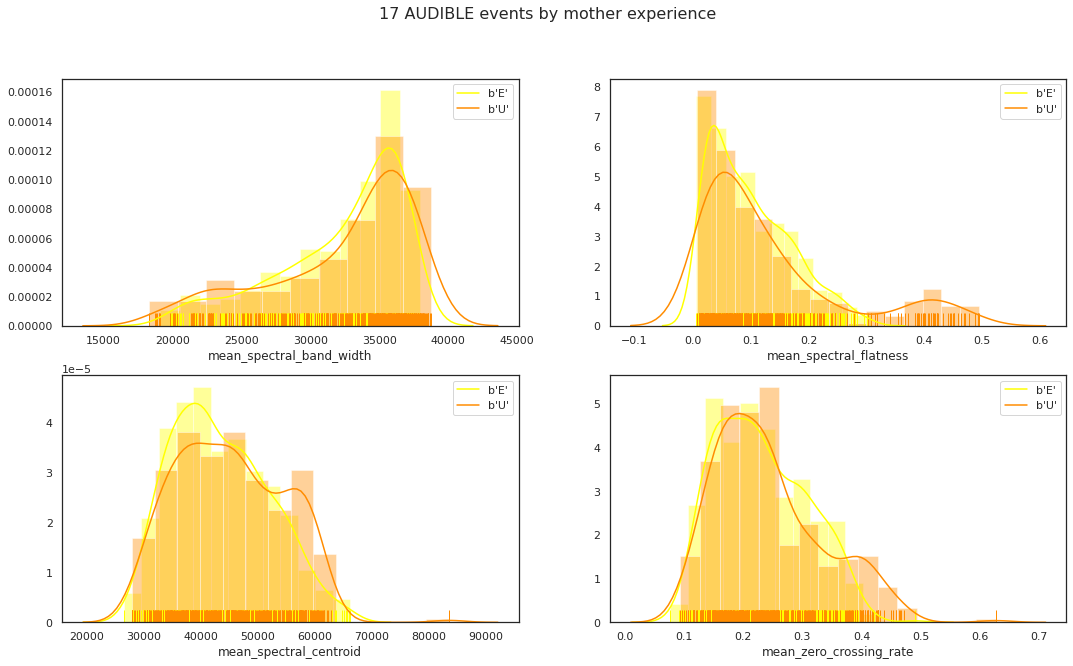

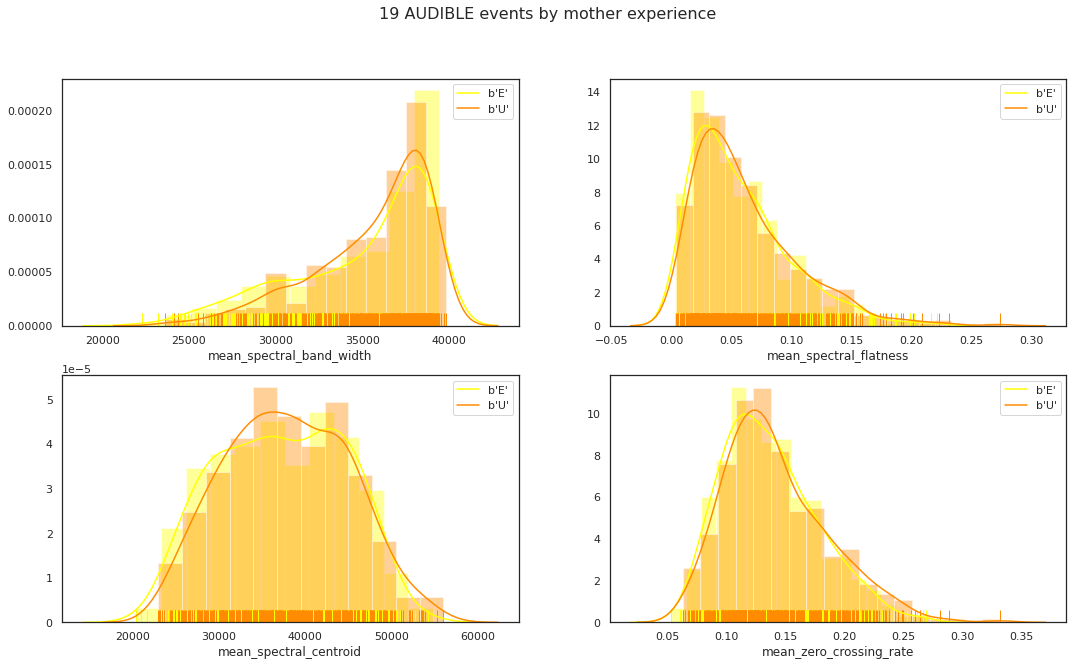

In [10]:
dicc_mothers = COLORS['mother']

M = {
    m: df[(df.mother == m) & (df.vocalization == 1)]
    for m in MOTHERS
}

for YEAR in [17, 19]:

    MY = {
        m: M[m][M[m].year == YEAR]
        for m in MOTHERS 
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by mother experience'
    f.suptitle(title, fontsize=16)

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_band_width, color=dicc_mothers[m], rug=True, ax=axes[0, 0], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_flatness, color=dicc_mothers[m], rug=True, ax=axes[0, 1], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_centroid, color=dicc_mothers[m], rug=True, ax=axes[1, 0], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_zero_crossing_rate, color=dicc_mothers[m], rug=True, ax=axes[1, 1], kde_kws={"label": f"{m}"})
    
    f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

# simple audio features distribution by NEST

In [11]:
dicc = COLORS['nest']

M = {
    m: df[(df.nest == m) & (df.vocalization == 1)]
    for m in NESTS
}

for YEAR in [17, 19]:

    MY = {
        m: M[m][M[m].year == YEAR]
        for m in NESTS
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by nest'
    f.suptitle(title, fontsize=16)
    
    
    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_band_width, color=dicc[m], hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_flatness,color=dicc[m], hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_centroid, color=dicc[m], hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_zero_crossing_rate, color=dicc[m], hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{m}"})
        
        f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

NameError: name 'NESTS' is not defined